<a href="https://colab.research.google.com/github/lpaolariosm/Investigaci-n-de-Operaciones-/blob/main/Proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <span style="color:red;">  ORGANIZACIÓN DE UN CONCIERTO </span>
<span style="color:black;"></span>

## 1. Introducción

En este proyecto se modela la planificación de un concierto mediante el método de la Ruta Crítica (CPM). Para ello:

- Se identifican las actividades clave (rentar lugar, contratar sonido, ensayo, campaña en redes y el concierto final).

- Se establece la duración de cada actividad y sus dependencias.

- Se construye la red en Python utilizando la librería NetworkX.

- Se calculan las fechas tempranas, tardías, holguras y la ruta crítica que determina la duración mínima del proyecto.

## 2. Tabla de Actividades

| ID | Actividad          | Duración (días) | Predecesores |
|----|--------------------|-----------------|--------------|
| A  | Rentar el lugar    | 2               | –            |
| B  | Contratar sonido   | 3               | A            |
| C  | Ensayo general     | 4               | B            |
| D  | Campaña en redes   | 5               | A            |
| E  | Concierto final    | 1               | C, D         |


## 3. Construcción de la red con NetworkX

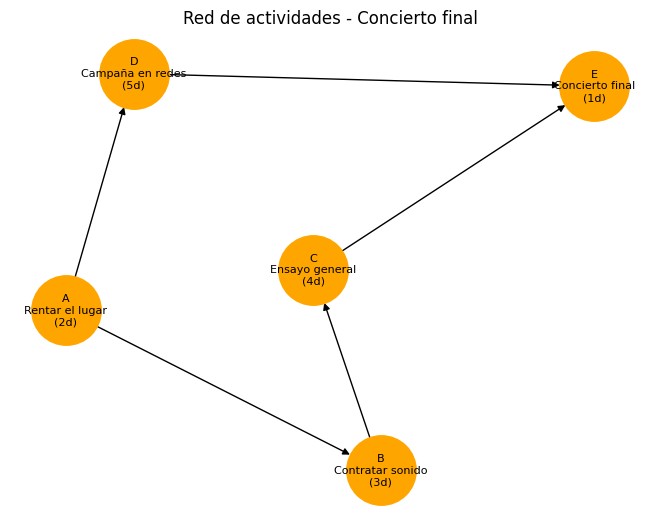

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Definición de actividades
actividades = {
    "A": ("Rentar el lugar", 2),
    "B": ("Contratar sonido", 3),
    "C": ("Ensayo general", 4),
    "D": ("Campaña en redes", 5),
    "E": ("Concierto final", 1)
}

# Dependencias
dependencias = [
    ("A", "B"),
    ("B", "C"),
    ("A", "D"),
    ("C", "E"),
    ("D", "E")
]

# Crear grafo
G = nx.DiGraph()
for nid, (name, dur) in actividades.items():
    G.add_node(nid, name=name, duration=dur)

G.add_edges_from(dependencias)

# Dibujar red
pos = nx.spring_layout(G, seed=42)
labels = {n: f"{n}\n{G.nodes[n]['name']}\n({G.nodes[n]['duration']}d)" for n in G.nodes()}
nx.draw(G, pos, with_labels=False, arrows=True, node_color="orange", node_size=2500)
nx.draw_networkx_labels(G, pos, labels, font_size=8)
plt.title("Red de actividades - Concierto final")
plt.show()


## 4. Cálculo de fechas tempranas, tardías y ruta crítica

In [ ]:
# Cálculo de ES, EF, LS, LF y ruta crítica
topo = list(nx.topological_sort(G))

# Fechas tempranas
ES, EF = {}, {}
for n in topo:
    preds = list(G.predecessors(n))
    ES[n] = max(EF[p] for p in preds) if preds else 0
    EF[n] = ES[n] + G.nodes[n]["duration"]

# Duración del proyecto
duracion_proyecto = max(EF.values())

# Fechas tardías
LF, LS = {}, {}
for n in reversed(topo):
    succs = list(G.successors(n))
    LF[n] = min(LS[s] for s in succs) if succs else duracion_proyecto
    LS[n] = LF[n] - G.nodes[n]["duration"]

# Holgura y ruta crítica
slack = {n: LS[n] - ES[n] for n in G.nodes()}
criticos = [n for n in G.nodes() if slack[n] == 0]

# Mostrar resultados
import pandas as pd
df = pd.DataFrame([
    [n, G.nodes[n]["name"], G.nodes[n]["duration"], ES[n], EF[n], LS[n], LF[n], slack[n], "Sí" if n in criticos else "No"]
    for n in topo
], columns=["ID", "Actividad", "Duración", "ES", "EF", "LS", "LF", "Holgura", "Crítica"])

print("Duración mínima del proyecto:", duracion_proyecto, "días")
print("Ruta crítica:", " → ".join(criticos))
df

Duración mínima del proyecto: 10 días
Ruta crítica: A → B → C → E


,ID,Actividad,Duración,ES,EF,LS,LF,Holgura,Crítica
0,A,Rentar el lugar,2,0,2,0,2,0,Sí
1,B,Contratar sonido,3,2,5,2,5,0,Sí
2,D,Campaña en redes,5,2,7,4,9,2,No
3,C,Ensayo general,4,5,9,5,9,0,Sí
4,E,Concierto final,1,9,10,9,10,0,Sí
